In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import sys
import graphviz 
# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')
    
import file_utils
import utils
import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from pathlib import Path
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn import tree
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)
print("sklearn version: ", sklearn.__version__)

Seaborn version:  0.9.0
sklearn version:  0.20.2


In [15]:
summary_team_file = '../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../Data/D1_teams.csv'
tournament_data_file = '../Data/tournament_results_2018.csv'
rankings_data_file = '../data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [16]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [17]:
# Do not use 2017-2018  for training, we'll hold that data back for testing a season in isolation

# These dates correspond to the year in which the tournament was played.
# For a start tournament date of 2003, the corresponding season is 2002-2003
start_tournament = 2003
stop_tournament = 2017

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [18]:
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


In [19]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

tourney_data = utils.recode_tourney_data(tourney_data)
tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor


In [20]:
feature_columns = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg',
                            'delta_def_rebs_avg', 'delta_ft_pct',
                            'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating',
                            'delta_ft_att_avg',
                            'delta_seed', 'delta_srs', 'delta_sos',
                            'delta_sag', 'delta_wlk', 'delta_wol',
                            'delta_rth', 'delta_col', 'delta_pom',
                            'delta_dol', 'delta_mor'] + ['season_t', 'top_conf_t', 'top_conf_o']

feature_data = tourney_comp_ratings[feature_columns].copy()
feature_data.head()

,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,season_t,top_conf_t,top_conf_o
0,2.0,0.007,1.0,1.0,0.063,0.0,-0.061,2.364814,2.0,-1,3.05,0.86,-8,12.0,8,2,12.0,5.0,-4.0,-39,2003,0,0
1,4.0,0.017,-1.0,-1.0,-0.002,-1.0,-0.009,7.042104,-5.0,-13,20.19,14.63,-131,-91.0,-104,-133,-73.0,-128.0,-85.0,-162,2003,1,0
2,5.0,-0.012,2.0,3.0,0.092,1.0,0.159,4.598761,6.0,-8,4.28,-1.38,-34,-38.0,-36,-33,-36.0,-33.0,-39.0,-24,2003,0,0
3,-6.0,0.022,1.0,-1.0,-0.026,3.0,-0.120,-4.525801,0.0,3,-1.93,4.63,23,31.0,13,12,17.0,27.0,21.0,6,2003,1,0
4,0.0,-0.029,3.0,-2.0,0.027,1.0,-0.069,-0.666215,1.0,-2,-0.11,0.25,-7,-7.0,2,-6,-5.0,-8.0,2.0,-9,2003,0,0


In [21]:
X= feature_data[feature_data['season_t']<= stop_tournament]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_mor',
 'top_conf_t',
 'top_conf_o']

####  Train Validate Test

In [22]:
X_train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
X_train_1, X_validate, y_train_1, y_validate = train_test_split(X_train_validate, y_train_validate, test_size=0.25, random_state = 5)
print("Total games= ", X.shape[0])
print("X Train_1: ",X_train_1.shape)
print("y_train_1", y_train_1.shape)
print("X Validate: ",X_validate.shape)
print("y_validate", y_validate.shape)
print("X Test: ",X_test.shape)
print(y_test.shape)

Total games=  978
X Train_1:  (586, 22)
y_train_1 (586,)
X Validate:  (196, 22)
y_validate (196,)
X Test:  (196, 22)
(196,)


In [23]:
number_estimators = 201
algorithm_choice = "SAMME.R"
ada= AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm=algorithm_choice, n_estimators=number_estimators)
    
ada.fit(X_train_1, y_train_1)
score = ada.score(X_train_1, y_train_1)
print("Training Model Score= ", score)


Training Model Score=  0.9914675767918089


#### Don't run this during show and tell...

In [26]:
#param_grid ={
#    "n_estimators": [51,101,201,301,401,501,601],
#    "learning_rate": [0.01, .05, .1, .5, 1,5]
#}

#grid_search = GridSearchCV( AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm=algorithm_choice), 
#                           param_grid=param_grid, cv=5)

#start = time()
#grid_search.fit(X_validate, y_validate)

#print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
#      % (time() - start, len(grid_search.cv_results_['params'])))
#report(grid_search.cv_results_)


In [27]:
number_estimators = 601
#number_estimators = 301
learning_rate = 0.5
#learning_rate = 1.0
ada= AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm=algorithm_choice, n_estimators=number_estimators,
                       learning_rate = learning_rate)

X_train = pd.concat([X_train_1, X_validate])
y_train = pd.concat([y_train_1, y_validate])
print("X Train: ",X_train.shape)
print(y_train.shape)

ada.fit(X_train, y_train)
score = ada.score(X_train, y_train)
print("Training Model Score= ", score)

X Train:  (782, 22)
(782,)
Training Model Score=  0.9808184143222506


In [28]:
important_features = utils.display_important_features( ada.feature_importances_, X_train)

Coefficient Values
delta_win_pct   0.1713810316139767
delta_sos   0.1447587354409318
delta_col   0.08652246256239601
delta_dol   0.0632279534109817
delta_sag   0.056572379367720464
delta_off_rating   0.051580698835274545
delta_rth   0.048252911813643926
delta_srs   0.04658901830282862
delta_wlk   0.04326123128119801
delta_ft_pct   0.04159733777038269
delta_margin_victory_avg   0.03993344425956739
delta_wol   0.03826955074875208
delta_fg_pct   0.03161397670549085
delta_mor   0.03161397670549085
delta_pom   0.028286189683860232
delta_seed   0.021630615640599003
delta_to_net_avg   0.016638935108153077
delta_ft_att_avg   0.016638935108153077
delta_off_rebs_avg   0.011647254575707155
delta_def_rebs_avg   0.009983361064891847
top_conf_t   0.0
top_conf_o   0.0


In [29]:
feature_dict={}
threshold_dict = {}
for stub_estimator in ada.estimators_:
    stub_tree = stub_estimator.tree_
    stub_feature_index = stub_tree.feature[0]
    stub_feature = X_train.columns[stub_feature_index]
    if stub_feature in feature_dict:
        feature_dict[stub_feature] +=1
        threshold_dict[stub_feature].append(stub_tree.threshold[0])
    else:
        feature_dict[stub_feature] = 1
        threshold_dict[stub_feature] = []
        threshold_dict[stub_feature].append(stub_tree.threshold[0])
        

feature_dict


{'delta_srs': 28,
 'delta_win_pct': 103,
 'delta_sos': 87,
 'delta_def_rebs_avg': 6,
 'delta_rth': 29,
 'delta_wlk': 26,
 'delta_col': 52,
 'delta_fg_pct': 19,
 'delta_dol': 38,
 'delta_wol': 23,
 'delta_ft_pct': 25,
 'delta_ft_att_avg': 10,
 'delta_mor': 19,
 'delta_pom': 17,
 'delta_margin_victory_avg': 24,
 'delta_off_rating': 31,
 'delta_seed': 13,
 'delta_to_net_avg': 10,
 'delta_sag': 34,
 'delta_off_rebs_avg': 7}

Delta Win Count=  1    103
Name: count, dtype: int64


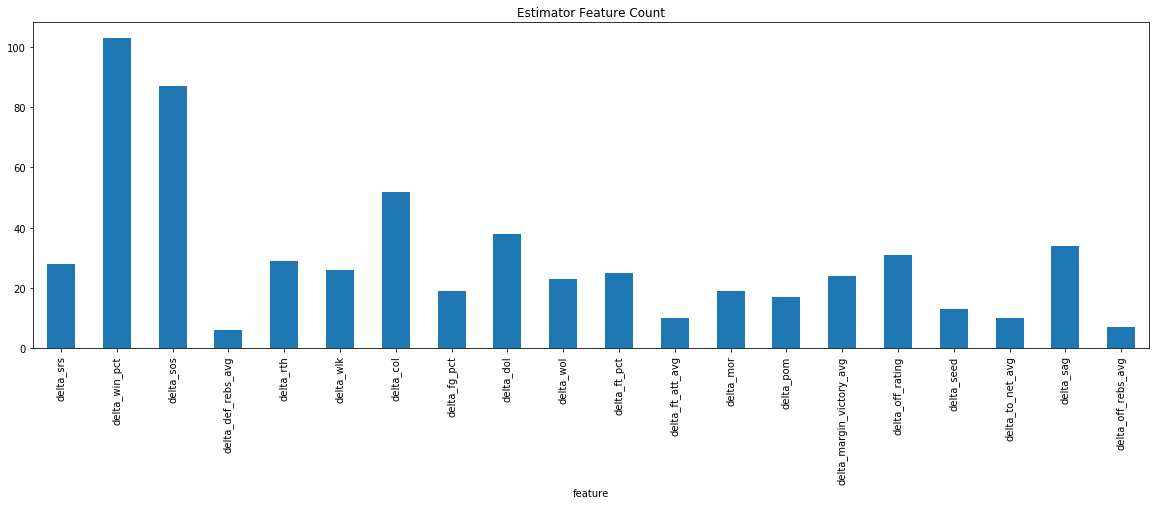

In [30]:
labels = list(feature_dict.keys())
values = list(feature_dict.values())


df = pd.DataFrame({'feature':labels, 'count':values})
ax = df.plot.bar(x='feature', y='count', legend=None)
ax.set_title('Estimator Feature Count')
ax.figure.set_size_inches(20,6)
print("Delta Win Count= ",df[df['feature']=='delta_win_pct']['count'])


Number of unique partitions=  26  out of  103  estimators


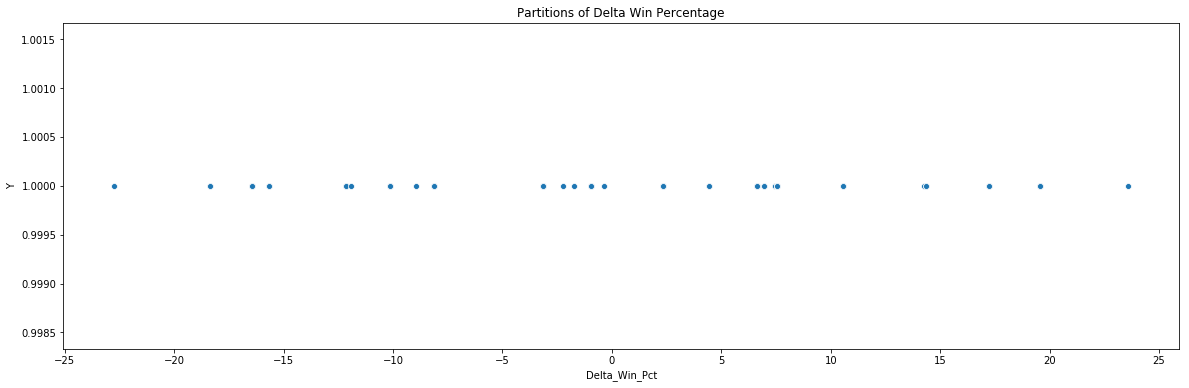

In [31]:
delta_win_partitions = threshold_dict['delta_win_pct']
delta_win_partitions = [i*100 for i in delta_win_partitions]

df_win = pd.DataFrame(columns=['Delta_Win_Pct','Y'])
df_win['Delta_Win_Pct'] = delta_win_partitions
df_win['Y'] = 1
df_win.sort_values(by='Delta_Win_Pct', inplace=True)
print("Number of unique partitions= ",df_win['Delta_Win_Pct'].unique().shape[0], " out of ", df_win.shape[0], ' estimators')

splot = sns.scatterplot(x='Delta_Win_Pct', y='Y', data=df_win)
splot.figure.set_size_inches(20,6)
splot.set_title('Partitions of Delta Win Percentage')
splot.set_xticks(np.arange(-25,30,5))
plt.show()

##### Note 75% duplicate delta win percentage estimators for 103  delta win percentage estimators

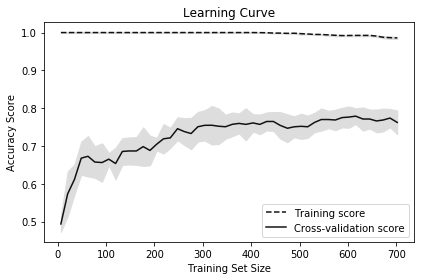

In [32]:
train_sizes, train_scores, test_scores = learning_curve(ada, X_train, y_train, cv=10, scoring='accuracy',
                                                        n_jobs=-1, 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### Test

In [33]:
y_pred = ada.predict(X_test)
print("AdaBoost model accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

AdaBoost model accuracy is 0.78


array([[61, 28],
       [15, 92]], dtype=int64)

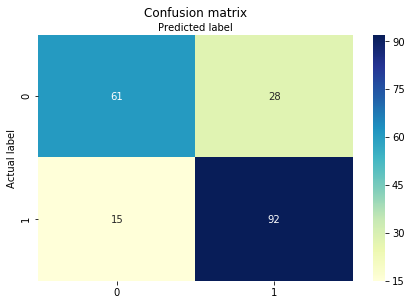

In [34]:
utils.display_confusion_matrix(y_test, y_pred)

In [35]:
prediction_probabilities = ada.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.7806122448979592
Precision: 0.7666666666666667
Recall: 0.8598130841121495
Log loss=  0.6817083876399654


In [36]:
cross_val_scores = cross_val_score(ada, X,y, cv=10, scoring='accuracy')
print("Cross Validation average= ",cross_val_scores.mean())

Cross Validation average=  0.788396802019777


In [37]:
# Retrieve the non-normalized game stats
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_test.index)].copy()

test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs
#test_games.head()

missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)

print("Missed predictions= ", missed_predictions.shape[0])
missed_predictions

Missed predictions=  43


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,predicted_result,pred_win_prob
816,2015,32,2015-03-21 00:00:00.0000000,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,71,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,68,-1,2014,Lose,23.13,7.55,0.917,76.0,60.0,0.470,0.731,73.861111,10.0,24.0,10.0,7.0,102.895825,22.0,14.11,9.72,0.611,70.0,65.0,0.436,0.686,75.550000,12.0,25.0,10.0,3.0,92.653872,20.0,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,0,0,1,16.0,5.0,11.0,0.034,-2.0,-1.0,0.045,3.0,7.0,-4.0,0.306,10.241954,2.0,-7,9.02,-2.17,-26,-29.0,-38,-30,-38.0,-33.0,-38.0,-18,1,0.531880
178,2005,32,2005-03-19 00:00:00.0000000,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,111,7,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,105,-1,2004,Lose,20.24,10.27,0.818,84.0,73.0,0.491,0.684,85.224242,14.0,25.0,14.0,8.0,98.563504,27.0,11.76,7.62,0.686,71.0,67.0,0.450,0.742,73.782857,9.0,20.0,11.0,8.0,96.228315,17.0,Atlantic Coast,Big 12,4,4.0,3,4,6.0,5.0,3.0,7.0,5,38,39.0,28,32,34.0,35.0,30.0,34.0,30,0,0,0,11.0,4.0,7.0,0.041,5.0,5.0,-0.058,6.0,3.0,3.0,0.132,2.335190,10.0,-5,8.48,2.65,-34,-35.0,-25,-28,-28.0,-30.0,-27.0,-25,1,0.518237
734,2014,16,2014-03-28 00:00:00.0000000,4,Louisville,b795ddbc-baab-4499-8803-52e8608520ab,74,8,Kentucky,2267a1f4-68f6-418b-aaf6-2aa0c4b291f1,69,-1,2013,Lose,24.69,4.80,0.838,81.0,61.0,0.471,0.661,80.837838,13.0,24.0,10.0,10.0,100.200602,24.0,18.07,9.90,0.725,74.0,66.0,0.454,0.682,78.510000,14.0,26.0,11.0,4.0,94.255509,28.0,Atlantic Coast,Southeastern,2,2.0,11,8,16.0,2.0,13.0,19.0,1,18,16.0,33,19,22.0,17.0,25.0,17.0,26,0,0,0,20.0,8.0,12.0,0.017,-1.0,-2.0,-0.021,0.0,7.0,-7.0,0.113,5.945093,-4.0,-4,6.62,-5.10,-16,-14.0,-22,-11,-6.0,-15.0,-12.0,-25,1,0.517012
852,2016,64,2016-03-18 00:00:00.0000000,3,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,70,14,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,56,-1,2015,Lose,21.61,9.78,0.743,78.0,66.0,0.449,0.673,85.394286,15.0,23.0,14.0,9.0,91.341006,27.0,9.23,-5.47,0.824,80.0,63.0,0.478,0.735,80.100000,11.0,23.0,12.0,9.0,99.875156,20.0,Big 12,Southland,6,6.0,8,8,11.0,6.0,7.0,10.0,11,57,55.0,62,101,83.0,33.0,80.0,62.0,36,1,0,1,12.0,17.0,-5.0,-0.029,4.0,0.0,-0.062,5.0,3.0,2.0,-0.081,-8.534150,7.0,-11,12.38,15.25,-51,-49.0,-54,-93,-72.0,-27.0,-73.0,-25,1,0.515674
778,2014,64,2014-03-21 00:00:00.0000000,3,Duke,faeb1160-5d15-4f26-99fc-c441cf21fc7f,78,14,Mercer,a14b0057-8eb5-43d2-a33b-666196da933e,71,-1,2013,Lose,19.51,8.48,0.743,78.0,67.0,0.460,0.729,76.034286,11.0,22.0,9.0,6.0,102.585300,22.0,5.33,-3.42,0.750,78.0,66.0,0.476,0.736,77.705556,11.0,25.0,11.0,5.0,100.378923,21.0,Atlantic Coast,Southern,7,8.0,15,9,14.0,6.0,14.0,9.0,8,89,97.0,90,124,93.0,95.0,100.0,81.0,94,1,0,1,11.0,12.0,-1.0,-0.016,0.0,-3.0,-0.007,3.0,6.0,-3.0,-0.007,2.206377,1.0,-11,14.18,11.90,-82,-89.0,-75,-115,-79.0,-89.0,-86.0,-86,1,0.512200
656,2013,64,2013-03-22 00:00:00.0000000,2,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,78,15,Florida Gulf Coast,5326c079-3dc3-468f-a601-b776dd9c1e62,68,-1,2012,Lose,15.84,7.59,0.781,64.0,56.0,0.453,0.679,71.050000,9.0,20.0,12

In [38]:
feature_dictionary = utils.Feature_Dictionary()
missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games, 
                                                                      x['season_t'], x['round'], x['team_t'] ), axis=1)


                                    Villanova       North Carolina State     Stat Supports Winner
SOS                              7.55                               9.72         True  (H)
Poss Avg                        73.86                              75.55         True  (H)
Off Rb Avg                      10.00                              12.00         True  (H)
Def Rb Avg                      24.00                              25.00         True  (H)
Seed                              1                                  8          False  (L)
SAG                              6.00                              32.00        False  (L)
WLK                              4.00                              33.00        False  (L)
WOL                              2.00                              40.00        False  (L)
RTH                              2.00                              32.00        False  (L)
COL                              2.00                              40.00        Fal

PPG                             74.00                              74.00        False  (H)
Off Rb Avg                      11.00                              12.00        False  (H)
Takeaway Avg                     7.00                               9.00        False  (H)
Win %                           79.50                              91.90        False  (H)
Off Rating                      96.00                              96.80        False  (H)

 Ohio State Wins.

Supporting Stat Count= 13  out of 25  stats.



                                       Lehigh                       Duke     Stat Supports Winner
Allow PPG                       65.00                              68.00         True  (L)
Turnover Avg                    11.00                              12.00         True  (L)
Net Turnover Avg                 4.00                               6.00         True  (L)
FT %                            76.80                              70.10         True  (H)
Takeaway Avg   

816    [(SOS                              7.55       ...
178    [(Allow PPG                       73.00       ...
734    [(SOS                              4.80       ...
852    [(Allow PPG                       66.00       ...
778    [(Allow PPG                       67.00       ...
656    [(PPG                             64.00       ...
128    [(Allow PPG                       65.00       ...
770    [(PPG                             67.00       ...
512    [(Net Turnover Avg                 4.00       ...
214    [(Allow PPG                       67.00       ...
334    [(Seed                             14         ...
388    [(Net Turnover Avg                 8.00       ...
106    [(Allow PPG                       65.00       ...
466    [(SAG                             20.00       ...
430    [(SOS                              8.61       ...
520    [(Seed                             10         ...
150    [(Allow PPG                       65.00       ...
752    [(PPG                   

In [39]:
supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, feature_dictionary, feature_list),
                                               axis=1)

missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)


missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

missed_predictions['game_index'] = missed_predictions.index
#missed_predictions.head()

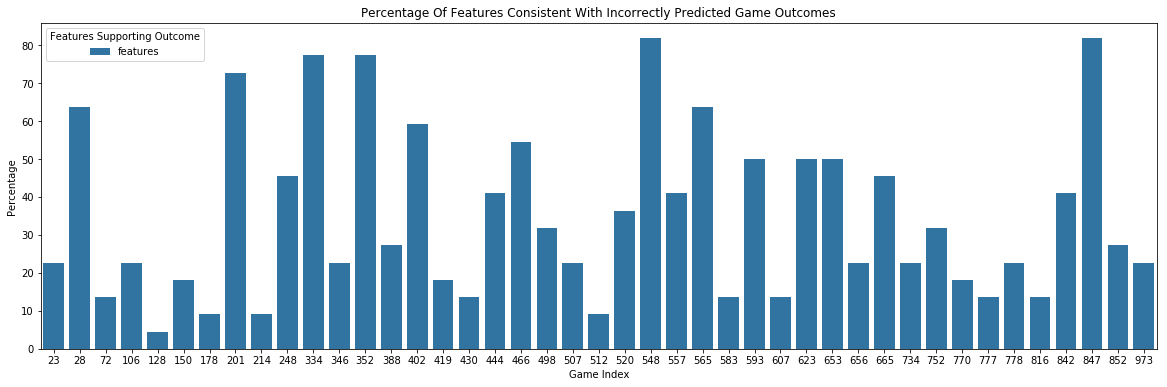

In [40]:
plot_missed_predictions_df = missed_predictions[['game_index','features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
#plot_missed_predictions_df.head()
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Incorrectly Predicted Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Game Index')
m_plot.figure.set_size_inches(20,6)

#### The bar chart depicts the percentage of features that correctly corresponded to the game outcome but were out weighed by other features in predicting the game incorrectly. Games corresponding to bar heights exceeding 50% should be scrutinized.

In [41]:
plot_missed_predictions_df[plot_missed_predictions_df['value'] > 50]

,game_index,Features Supporting Outcome,value
10,334,features,77.272727
13,466,features,54.545455
22,548,features,81.818182
23,402,features,59.090909
24,28,features,63.636364
25,352,features,77.272727
28,565,features,63.636364
31,847,features,81.818182
33,201,features,72.727273


##### Examine a missed prediction

In [42]:
missed_prediction_index = 334
# get the list of features that suported the correct game oputcome
list_features =missed_predictions.loc[missed_prediction_index]['supporting_features']

In [43]:
for item in list_features:
    print(item)

margin_victory_avg
fg_pct
ft_pct
to_net_avg
win_pct
off_rating
ft_att_avg
seed
srs
sag
wlk
wol
rth
col
pom
dol
mor


In [44]:
missed_game_record = missed_predictions.loc[missed_prediction_index]
missed_game_record

season_t                                                                 2008
round                                                                      64
game_date                                         2008-03-20 00:00:00.0000000
seed_t                                                                     14
team_t                                                                Georgia
team_id_t                                4f4b0771-994c-4126-822d-7525aaa00f65
win_pts                                                                    73
seed_o                                                                      3
team_o                                                                 Xavier
team_id_o                                0d8a328f-20ce-410b-bed1-15fc01308aaf
lose_pts                                                                   61
game_result                                                                -1
start_season                                                    

In [45]:
# staged_predict
missed_game = X.loc[missed_prediction_index].to_frame().T
missed_game
staged_predictions = ada.staged_predict(missed_game)
item_count =0
estimators=[]
values = []
for item in staged_predictions:
    # print(item_count, item)
    estimators.append(item_count)
    values.append(item[0])
    item_count += 1

In [46]:
df = pd.DataFrame.from_dict({'Estimator':estimators,'Value':values})

decision_func = []
for item in ada.staged_decision_function(missed_game):
    decision_func.append(item[0])
    #print(item)
df['Decision'] = decision_func

predict_prob = []
for item in ada.staged_predict_proba(missed_game):
    predict_prob.append(item[0][0])
df['Predict_Prob'] = predict_prob 

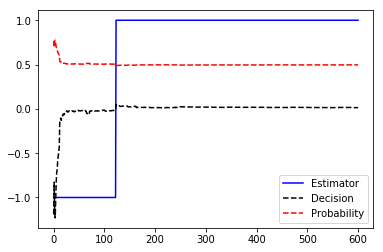

In [47]:
plt.plot('Estimator', 'Value', data= df, marker='', color='blue', label = 'Estimator')
plt.plot('Estimator', 'Decision', data= df, marker='', color='black', linestyle='dashed', label='Decision')
plt.plot('Estimator', 'Predict_Prob', data= df, marker='', color='red', linestyle='dashed', label='Probability')
plt.legend()

In [48]:
# staged_score
staged_score_generator = ada.staged_score(missed_game,[1])
count =0
for item in staged_score_generator:
    print(count, item)
    count+=1

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 0.0
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 0.0
121 0.0
122 0.0
123 1.0
124 1.0
125 1.0
126 1.0
127 1.0
128 1.0
129 1.0
130 1.0
131 1.0
132 1.0
133 1.0
134 1.0
135 1.0
136 1.0
137 1.0
138 1.

In [49]:
#ada.estimator_errors_

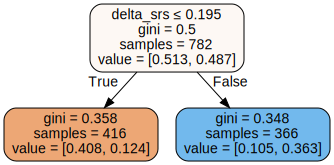

In [50]:
tree_stubs = ada.estimators_
stub_graph_data = []
for stub in tree_stubs:
    dot_data = tree.export_graphviz(stub,out_file=None, 
                                feature_names= list(X),filled=True, rounded=True, special_characters=True, proportion=False)
    stub_graph_data.append(dot_data)

graphviz.Source(stub_graph_data[0])


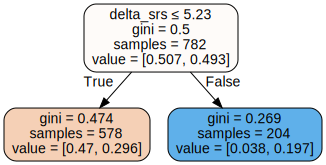

In [51]:
graphviz.Source(stub_graph_data[1])

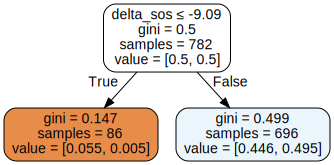

In [52]:
graphviz.Source(stub_graph_data[5])

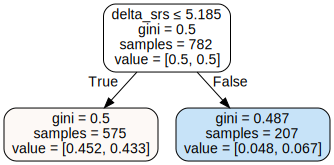

In [53]:
graphviz.Source(stub_graph_data[332])

In [54]:
stub_graph_data[5]

'digraph Tree {\nnode [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;\nedge [fontname=helvetica] ;\n0 [label=<delta_sos &le; -9.09<br/>gini = 0.5<br/>samples = 782<br/>value = [0.5, 0.5]>, fillcolor="#e5813900"] ;\n1 [label=<gini = 0.147<br/>samples = 86<br/>value = [0.055, 0.005]>, fillcolor="#e58139e9"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label=<gini = 0.499<br/>samples = 696<br/>value = [0.446, 0.495]>, fillcolor="#399de519"] ;\n0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n}'

In [55]:
 ada.estimators_[5]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=1163942795, splitter='best')

In [56]:
help(tree._tree.Tree)


Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The maximal depth of the tree.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child of node i.
 |      For leaves,

In [57]:
stub_5 =  ada.estimators_[5]
stub_5.classes_


array([-1,  1], dtype=int64)

In [58]:
stub_5.tree_.value

array([[[0.50040809, 0.49959191]],

       [[0.05464898, 0.0047287 ]],

       [[0.44575911, 0.49486321]]])

In [59]:
stub_5.tree_.weighted_n_node_samples

array([1.        , 0.05937768, 0.94062232])

In [60]:
stub_5.tree_.n_node_samples

array([782,  86, 696], dtype=int64)

In [61]:
stub_5.tree_.impurity

array([0.49999967, 0.14659103, 0.49863738])

### 2018 Tournament Predictions

In [62]:
test_year = 2018
X_season = feature_data[feature_data['season_t']== test_year]
y_season = tourney_comp_ratings[tourney_comp_ratings['season_t']== test_year]['game_result']
X_season= X_season.drop(columns=['season_t'])
X_season.shape

(67, 22)

array([[22, 11],
       [ 7, 27]], dtype=int64)

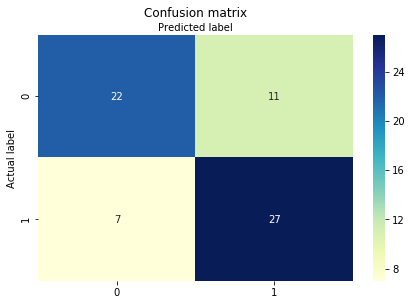

In [63]:
y_pred_season = ada.predict(X_season)
utils.display_confusion_matrix(y_season,y_pred_season)

In [64]:
prediction_probabilities =  ada.predict_proba(X_season)
print("Accuracy:",metrics.accuracy_score(y_season, y_pred_season))
print("Precision:", metrics.precision_score(y_season,y_pred_season))
print("Recall:",metrics.recall_score(y_season, y_pred_season))
print("Log loss= ",log_loss(y_season, prediction_probabilities))

Accuracy: 0.7313432835820896
Precision: 0.7105263157894737
Recall: 0.7941176470588235
Log loss=  0.6804238906364
